In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def vis(A, B): 
    import itertools
    vertices = []
    # For each square submatrix
    for ix in itertools.combinations(range(A.shape[1]), A.shape[0]):
        m = A[:,ix]
        # If invertible
        if np.linalg.det(m) == 0: continue
        # Solve and add the vertex
        vertices.append(B[list(ix)].dot(np.linalg.inv(m)))

    # Apply full constraints
    vertices = np.array(vertices)
    ix = (vertices.dot(A) <= B[None,:]).all(axis=1)
    vertices = vertices[ix].copy()

    # Starting point
    point = vertices.mean(axis=0)
    
    XX, YY = np.meshgrid(*[np.linspace(-2,3,201)]*2)
    rs = np.array([XX,YY])
    rs = np.transpose(rs,axes=(1,2,0)).reshape((-1,2))
    figsize(8,8)
    region = (np.dot(A.T,rs.T) <= B[:,None]).all(axis=0).reshape((201,201))
    pcolor(XX,YY,region,cmap='Greens')
    scatter(*vertices.T, s=100, c='b',label='Vertices')
    scatter(*point, s=100, c='r', label='Sample Point')
    legend()

## Codegenerator

In [2]:
import itertools

class SampleCodeGen(object):
    def __init__(self):
        self.code = []
    
    def a(self, i, j):
        return "A[{},{}]".format(j,i)
    def b(self, i):
        return "B[{}]".format(i)
        
    def gen_detA(self, indices, cramer_column=None):
        code = ""
        parity , first = 1 , True
        for p in itertools.permutations(indices):
            if not first:
                code += " + " if parity == 1 else " - "
            first = False
            parity = -parity
            prod = (self.a(j,i) if i != cramer_column else self.b(j) for i,j in enumerate(p))
            code += "*".join(prod)
        return code
    
    def cg(self, code, indent):
        indent = "    " * indent
        self.code.append(indent + code)
    
    def generate(self, n, d):
        self.code = []
        self.cg("def sample(A,B):", 0)
        self.cg("n = 0", 1)
        for j in range(d):
            self.cg("v{} = 0".format(j),1)
            
        for minor, indices in enumerate(itertools.combinations(range(n), d)):
            self.cg("d{} = {}".format(minor, self.gen_detA(indices)), 1)
            self.cg("if d{} != 0:".format(minor), 1)
            for j in range(d):
                detj = self.gen_detA(indices, cramer_column=j)
                self.cg("x{} = ({}) / d{}".format(j, detj, minor), 2)
            for i in range(n):
                if i in indices: continue
                s = ("{}*x{}".format(self.a(i,j),j) for j in range(d))
                self.cg("c{} = {} <= {}".format(i," + ".join(s), self.b(i)), 2)
            c = ("c{}".format(i) for i in range(n) if i not in indices)
            self.cg("if {}:".format(" and ".join(c)), 2)
            self.cg("n += 1", 3)
            for j in range(d):
                self.cg("v{} += x{}".format(j,j), 3)            
    
        for j in range(d):
            self.cg("v{} /= n".format(j), 1)
        r = ",".join("v{}".format(j) for j in range(d))
        self.cg("return ({})".format(r), 1)
    
    def get_code(self):
        return "\n".join(cg.code)

## Test: (4,2)

In [9]:
cg = SampleCodeGen()
cg.generate(4,2)
exec(cg.get_code())

In [13]:
print(cg.get_code())

def sample(A,B):
    n = 0
    v0 = 0
    v1 = 0
    d0 = A[0,0]*A[1,1] - A[0,1]*A[1,0]
    if d0 != 0:
        x0 = (B[0]*A[1,1] - B[1]*A[1,0]) / d0
        x1 = (A[0,0]*B[1] - A[0,1]*B[0]) / d0
        c2 = A[0,2]*x0 + A[1,2]*x1 <= B[2]
        c3 = A[0,3]*x0 + A[1,3]*x1 <= B[3]
        if c2 and c3:
            n += 1
            v0 += x0
            v1 += x1
    d1 = A[0,0]*A[1,2] - A[0,2]*A[1,0]
    if d1 != 0:
        x0 = (B[0]*A[1,2] - B[2]*A[1,0]) / d1
        x1 = (A[0,0]*B[2] - A[0,2]*B[0]) / d1
        c1 = A[0,1]*x0 + A[1,1]*x1 <= B[1]
        c3 = A[0,3]*x0 + A[1,3]*x1 <= B[3]
        if c1 and c3:
            n += 1
            v0 += x0
            v1 += x1
    d2 = A[0,0]*A[1,3] - A[0,3]*A[1,0]
    if d2 != 0:
        x0 = (B[0]*A[1,3] - B[3]*A[1,0]) / d2
        x1 = (A[0,0]*B[3] - A[0,3]*B[0]) / d2
        c1 = A[0,1]*x0 + A[1,1]*x1 <= B[1]
        c2 = A[0,2]*x0 + A[1,2]*x1 <= B[2]
        if c1 and c2:
            n += 1
            v0 += x0
            v1 += x1
   

In [11]:
from utils import parse_constraints
constraints = """
  x <= 2
  x >= -1
  x + y >= 0
  y + 0.5 * x <= 2 
"""
variables = ['x','y']

A, B = parse_constraints(constraints, variables)
A, B = np.array([A[v] for v in variables]), np.array(B)

# A .  x <= B
print(A)
print(B)

[[ 1.  -1.  -1.   0.5]
 [ 0.  -0.  -1.   1. ]]
[ 2.  1. -0.  2.]


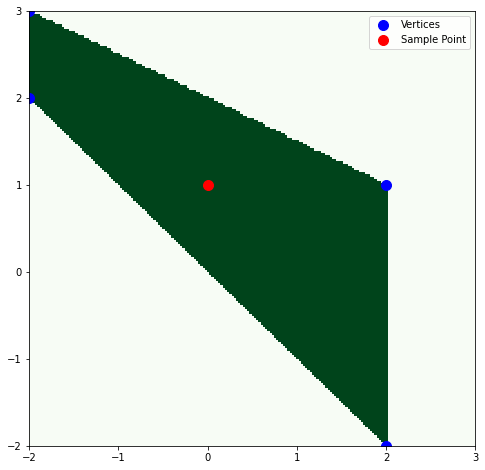

In [7]:
vis(A,B)

In [12]:
sample(A,B)

(0.5, 0.625)

## Test (6,3)

In [21]:
cg = SampleCodeGen()
cg.generate(6,3)
exec(cg.get_code())

In [24]:
#print(cg.get_code())

In [34]:
from utils import parse_constraints
constraints = """
  x <= 2
  x >= 0
  x + y >= 0
  y + 0.5 * x <= 2  
  z >= 2
  z + y + x <= 5
"""
variables = ['x','y','z']

A, B = parse_constraints(constraints, variables)
A, B = np.array([A[v] for v in variables]), np.array(B)

print(A)
print(B)

[[ 1.  -1.  -1.   0.5 -0.   1. ]
 [ 0.  -0.  -1.   1.  -0.   1. ]
 [ 0.  -0.  -0.   0.  -1.   1. ]]
[ 2. -0. -0.  2. -2.  5.]


In [35]:
sample(A,B)

(0.6666666666666666, 1.0952380952380951, 3.0)

## Random sampling

In [14]:
import itertools

class RanSampCodeGen(object):
    def __init__(self):
        self.code = []
    
    def a(self, i, j):
        return "A[{},{}]".format(j,i)
    def b(self, i):
        return "B[{}]".format(i)
        
    def gen_detA(self, indices, cramer_column=None):
        code = ""
        parity , first = 1 , True
        for p in itertools.permutations(indices):
            if not first:
                code += " + " if parity == 1 else " - "
            first = False
            parity = -parity
            prod = (self.a(j,i) if i != cramer_column else self.b(j) for i,j in enumerate(p))
            code += "*".join(prod)
        return code
    
    def cg(self, code, indent):
        indent = "    " * indent
        self.code.append(indent + code)
    
    def generate(self, n, d):
        self.code = []
        self.cg("def rand_sample(A,B,size=1):", 0)
        self.cg("v = []", 1)            
        for minor, indices in enumerate(itertools.combinations(range(n), d)):
            self.cg("d{} = {}".format(minor, self.gen_detA(indices)), 1)
            self.cg("if d{} != 0:".format(minor), 1)
            for j in range(d):
                detj = self.gen_detA(indices, cramer_column=j)
                self.cg("x{} = ({}) / d{}".format(j, detj, minor), 2)
            for i in range(n):
                if i in indices: continue
                s = ("{}*x{}".format(self.a(i,j),j) for j in range(d))
                self.cg("c{} = {} <= {}".format(i," + ".join(s), self.b(i)), 2)
            c = ("c{}".format(i) for i in range(n) if i not in indices)
            self.cg("if {}:".format(" and ".join(c)), 2)
            x = ("x{}".format(j) for j in range(d))
            self.cg("v.append([{}])".format(",".join(x)), 3) 
            
        
        self.cg("n = len(v)", 1)
        self.cg("v = np.array(v)", 1)
        self.cg("weights = np.random.uniform(size=size*(n+1)).reshape(size, -1)", 1)
        self.cg("weights[:, 0] = 0.0", 1)
        self.cg("weights[:, n-1] = 1.0", 1)
        self.cg("weights = np.diff(np.sort(weights,axis=1), axis=1)", 1)        
        
        self.cg("return weights.dot(v)", 1)
        
    def get_code(self):
        return "\n".join(cg.code)

In [15]:
cg = RanSampCodeGen()
cg.generate(4,2)
exec(cg.get_code())

In [19]:
from utils import parse_constraints
constraints = """
  x <= 3
  x >= 0
  x + y >= 0
  y + 0.5 * x <= 2 
"""
variables = ['x','y']

A, B = parse_constraints(constraints, variables)
A, B = np.array([A[v] for v in variables]), np.array(B)

print(A)
print(B)

[[ 1.  -1.  -1.   0.5]
 [ 0.  -0.  -1.   1. ]]
[ 3. -0. -0.  2.]


In [17]:
rand_sample(A, B, size=50)

array([[ 1.56231073e+00,  5.18053645e-01],
       [-6.17614673e-01,  2.07101427e+00],
       [ 1.12662992e+00,  6.33233572e-01],
       [ 7.21789479e-02,  4.47199250e-01],
       [-5.45676800e-01,  1.81086811e+00],
       [-6.92336670e-01,  1.29480318e+00],
       [-2.81039531e-01,  1.30228033e+00],
       [ 3.44535441e-01,  1.27299297e+00],
       [ 1.11021615e+00,  9.03049843e-01],
       [ 1.78279713e+00,  6.27772012e-01],
       [ 2.07201792e+00, -3.89416338e-01],
       [ 2.31693409e-01,  1.32395237e+00],
       [ 1.39454102e+00,  7.81633339e-01],
       [-4.35199916e-01,  7.95139212e-01],
       [ 1.72027880e+00,  3.95918033e-01],
       [ 4.08194854e-01,  8.32687988e-01],
       [-1.05979628e+00,  1.48713858e+00],
       [-5.22624781e-01,  1.34429490e+00],
       [ 3.44627286e-01,  1.60080897e+00],
       [ 6.07120768e-01,  1.06060817e+00],
       [ 2.23654922e+00,  4.31197828e-01],
       [ 7.21273848e-01,  1.64119396e-01],
       [ 9.20614983e-01, -6.35528921e-01],
       [ 1.

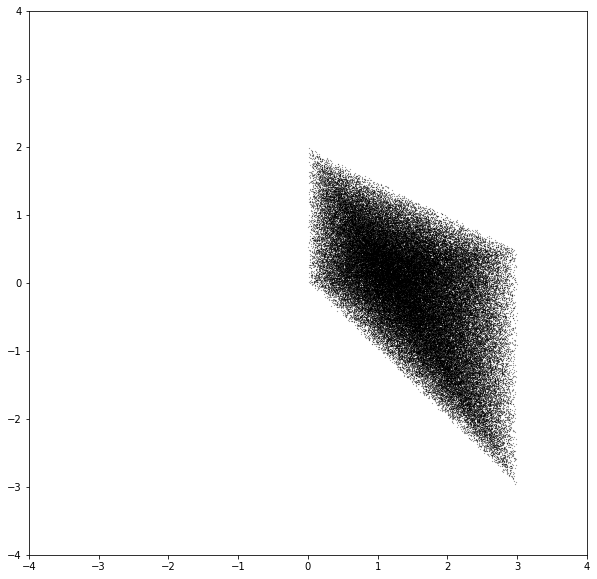

In [20]:
x,y = rand_sample(A,B, size=100000).T
figsize(10,10)
scatter(x,y,c='k',marker='.',s=0.1); 
xlim(-4,4); ylim(-4,4);

In [35]:
from utils import parse_constraints

variables = ['x','y']
constraints1 = """
  x <= 3
  x >= -2
  x + y >= 0
  y + 0.5 * x <= 2 
"""
constraints2 = """
  x + y >= -3
  x - y >= -2
  x  <= 2
  y + 0.5 * x <= 2 
"""
constraints3 = """
  x <= 3
  y >= -3
  x - 0.3 * y >= 0
  y + 0.5 * x <= 2 
"""

A1, B1 = parse_constraints(constraints1, variables)
A1, B1 = np.array([A1[v] for v in variables]), np.array(B1)
A2, B2 = parse_constraints(constraints2, variables)
A2, B2 = np.array([A2[v] for v in variables]), np.array(B2)
A3, B3 = parse_constraints(constraints3, variables)
A3, B3 = np.array([A3[v] for v in variables]), np.array(B3)

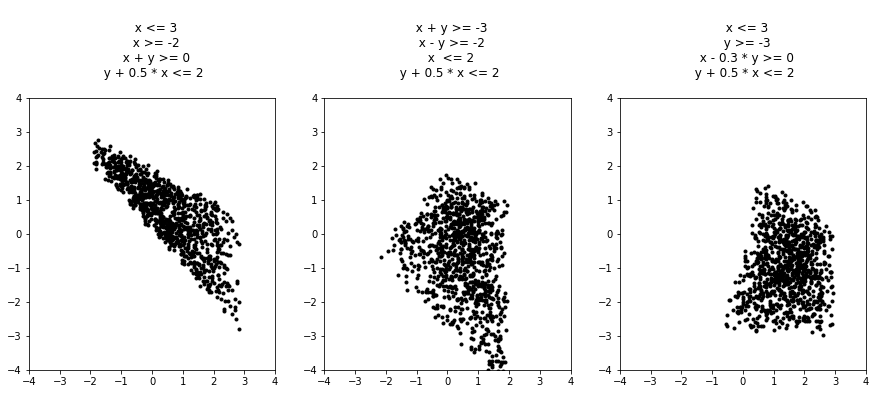

In [36]:
figsize(15,5)

subplot(131)
title(constraints1)
x,y = rand_sample(A1,B1, size=1000).T
scatter(x,y,c='k',marker='.'); 
xlim(-4,4); ylim(-4,4);

subplot(132)
title(constraints2)
x,y = rand_sample(A2,B2, size=1000).T
scatter(x,y,c='k',marker='.'); 
xlim(-4,4); ylim(-4,4);

subplot(133)
title(constraints3)
x,y = rand_sample(A3,B3, size=1000).T
scatter(x,y,c='k',marker='.'); 
xlim(-4,4); ylim(-4,4);
